# FPL Prediction: EDA

Notebook used to explore and visualise FPL data in order to predict player level points

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.configs.data_config import IDENTIFIERS, REALS, CATEGORIES, TARGET

Show summary of input data

## Data Overview

Show information relating to data counts, columns and types...

In [2]:
fpl_data = pd.read_csv('./data/interim/raw.csv',index_col=0)
fpl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87452 entries, 0 to 87451
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uid           87452 non-null  int64  
 1   element       87452 non-null  int64  
 2   season        87452 non-null  object 
 3   name          87452 non-null  object 
 4   fixture       87452 non-null  int64  
 5   GW            87452 non-null  int64  
 6   value         87452 non-null  int64  
 7   bps           87452 non-null  int64  
 8   influence     87452 non-null  float64
 9   creativity    87452 non-null  float64
 10  threat        87452 non-null  float64
 11  ict_index     87452 non-null  float64
 12  minutes       87452 non-null  int64  
 13  fdr_player    87452 non-null  int64  
 14  fdr_diff      87452 non-null  int64  
 15  position      87452 non-null  object 
 16  was_home      87452 non-null  bool   
 17  total_points  87452 non-null  int64  
dtypes: bool(1), float64(4), in

We would like to be able to predict the output points for multipele steps in the future (y):

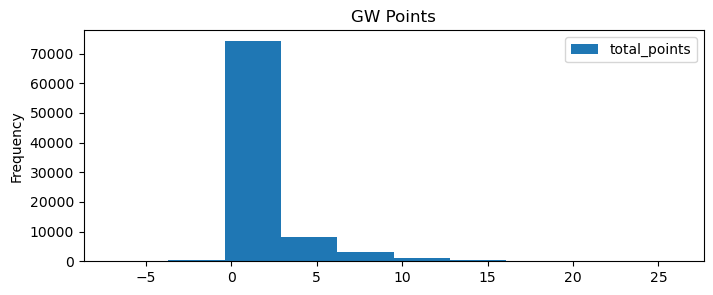

In [3]:
fpl_data[TARGET].plot.hist(bins=10,figsize=(8,3),title="GW Points")
plt.show()

We would like to do this from usng the following continuous X vals

In [4]:
fpl_data.loc[:,REALS].describe()

,value,bps,influence,creativity,threat,ict_index,minutes,fdr_player,fdr_diff
count,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000,87452.000000
mean,51.424656,5.904931,7.155701,4.688437,5.367630,1.720276,32.196473,2.952866,0.015380
std,12.312933,9.647543,12.788871,10.616842,13.573716,3.035137,40.581256,0.915772,1.327307
min,37.000000,-16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-3.000000
25%,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,-1.000000
50%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
75%,55.000000,10.000000,10.800000,2.500000,2.000000,2.500000,90.000000,4.000000,1.000000
max,136.000000,99.000000,144.000000,136.200000,181.000000,35.800000,90.000000,5.000000,3.000000


Show individual example

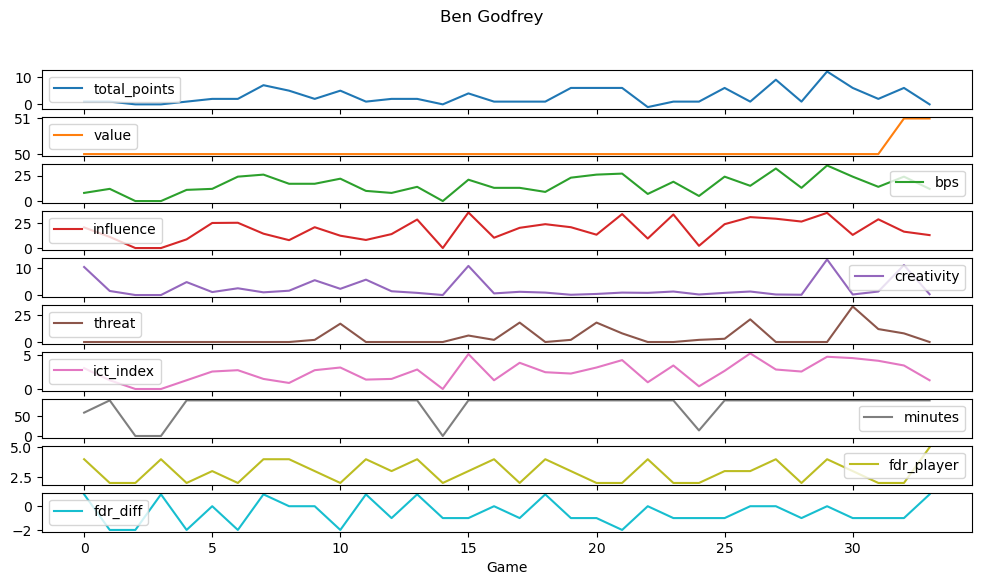

In [53]:
def plot_example(random_state=18):
    """Function to sample random player/season and plot contuninuous vals"""
    random_id = fpl_data.uid.drop_duplicates().sample(1,random_state=random_state).values[0]
    player_details = fpl_data[lambda x: x.uid==random_id].head(1).loc[:,['name','season']]
    fpl_data.loc[fpl_data.uid==random_id,TARGET+REALS].reset_index(drop=True).\
                        plot(subplots=True,xlabel='Game',title=player_details.name.values[0],figsize=(12,6))
    plt.show()
plot_example()

One aspect to be cautious of is the distribution of the target output.

The below plots show the total points of the season, we see there is a large population fo players who don't play at all. Or, play very few games.


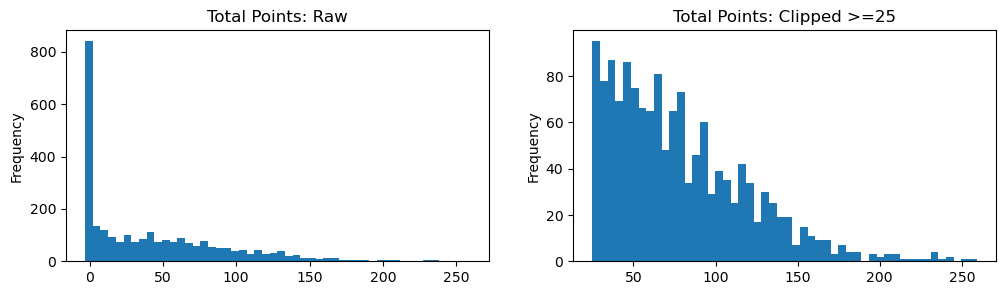

In [94]:
fig,axs = plt.subplots(1, 2,figsize = (12,3))
fpl_data.groupby('uid').sum().total_points.plot.hist(bins=50,ax=axs[0],title='Season Total Points: Raw')
fpl_data.groupby('uid').sum().total_points[lambda x:x>=25].plot.hist(bins=50,ax=axs[1],title='Season Total Points: Clipped >=25')
plt.show()

In [96]:
points_ge25 = fpl_data.groupby('uid')['total_points'].transform(lambda x:x.sum()>=25)

## Correlations

In [6]:
from src.data.feature_processing import crosscorr

The below plot shows the correlations (Spearman) going back 30 lags.

The incremental correlation appears to flatten after ~12 lags for those variables that demonstrate dynamic dependencies.

The variables 'Value', 'fdr_player' and 'fdr_diff' remain flat suggesting they should not be modelled dynamically but instead included as a fixed/static feature

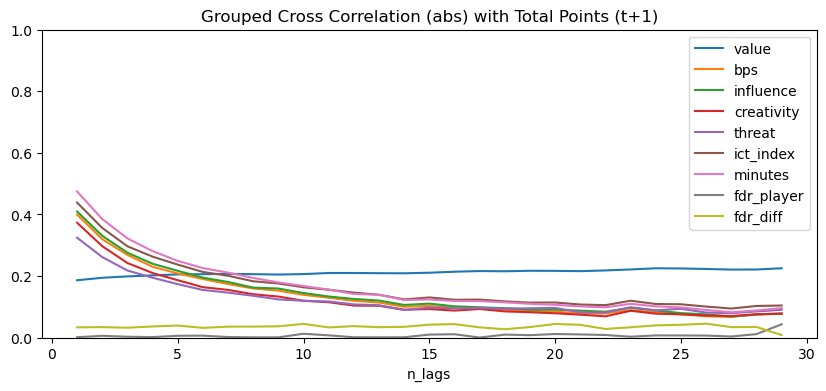

In [97]:
n_lags=30
corr_df = pd.DataFrame(index=list(range(1,n_lags)))
for col in REALS:
  corr_df[col] = [crosscorr(data=fpl_data[points_ge25],x_col=col,y_col='total_points', lag=i) for i in range(1,n_lags)]

corr_df.abs().plot(title='Grouped Cross Correlation (abs) with Total Points (t+1)',xlabel='n_lags',figsize=(10,4),ylim=(0,1))
plt.show()

Lets also have a look at the static correlations i.e. without lags

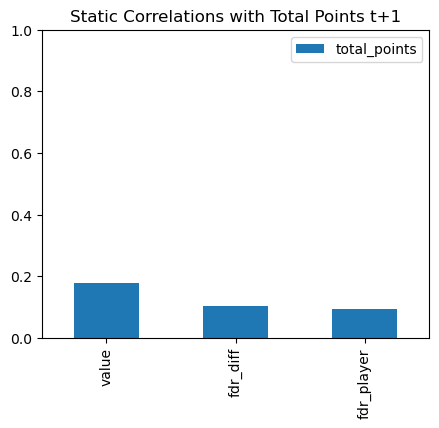

In [101]:
fpl_data.loc[points_ge25,['total_points','value','fdr_player','fdr_diff']].corr('spearman')[TARGET].abs()\
        .drop(TARGET,axis=0)\
            .sort_values(TARGET,ascending=False)\
                .plot.bar(ylim=(0,1),title='Static Correlations with Total Points t+1',figsize=(5,4))
plt.show()

## Feature Importance

In [121]:
from src.configs.data_config import TIME_VARYING_UNKNOWN_REALS, TIME_VARYING_KNOWN_REALS,STATIC_REALS,STATIC_CATEGORICALS,TARGET
print(f"TIME_VARYING_UNKNOWN_REALS:{TIME_VARYING_UNKNOWN_REALS}",f"TIME_VARYING_KNOWN_REALS:{TIME_VARYING_KNOWN_REALS}" ,
f"STATIC_REALS:{STATIC_REALS}",f"STATIC_CATEGORICALS:{STATIC_CATEGORICALS}",f"TARGET:{TARGET}",sep='\n')

TIME_VARYING_UNKNOWN_REALS:['bps', 'influence', 'creativity', 'threat', 'ict_index', 'minutes']
TIME_VARYING_KNOWN_REALS:['fdr_player', 'fdr_diff']
STATIC_REALS:['value']
STATIC_CATEGORICALS:['position', 'was_home']
TARGET:['total_points']


In [173]:
n_lags = 20
TIME_VARYING_UNKNOWN_REALS
time_varying_unknown_reals_X = pd.DataFrame(index=fpl_data[points_ge25].index)
for col in TIME_VARYING_UNKNOWN_REALS:
    for lag in range(1,n_lags+1):
        time_varying_unknown_reals_X [f'{col}_l{lag}'] = fpl_data[points_ge25].groupby('uid')[col].shift(lag)
TIME_VARYING_UNKNOWN_REALS_TRANSFORMED = time_varying_unknown_reals_X.columns.values.tolist()

time_varying_known_reals_X = fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS]
X = fpl_data.loc[points_ge25,TIME_VARYING_KNOWN_REALS+STATIC_REALS+STATIC_CATEGORICALS]
X = X.merge(time_varying_unknown_reals_X,how='left',left_index=True,right_index=True)
y= fpl_data.loc[points_ge25,TARGET]


<ipython-input-173-da4a7db360e7>:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  time_varying_unknown_reals_X [f'{col}_l{lag}'] = fpl_data[points_ge25].groupby('uid')[col].shift(lag)


In [175]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,LabelEncoder
from sklearn.pipeline import Pipeline

In [176]:
#DYNAMIC DATA

numeric_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value=-100)),
       ('scaler',  StandardScaler())])

categorical_transformer = Pipeline(steps=[
       ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
       ('one_hot', OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, TIME_VARYING_UNKNOWN_REALS_TRANSFORMED +TIME_VARYING_KNOWN_REALS+STATIC_REALS),
        ('cats', categorical_transformer, STATIC_CATEGORICALS)])


In [276]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression

model_pipe = Pipeline(steps=[('preprocessor',preprocessor),('regr',LassoCV(cv=5, random_state=0,max_iter=8000))]).fit(X,y)

C:\Users\matth\miniconda3\envs\pysam_env\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [277]:
processor_names = TIME_VARYING_UNKNOWN_REALS_TRANSFORMED +TIME_VARYING_KNOWN_REALS+STATIC_REALS+model_pipe['preprocessor'].transformers_[1][1]\
    ['one_hot'].get_feature_names(STATIC_CATEGORICALS).tolist()

In [278]:
importances = pd.Series(model_pipe['regr'].coef_,index=processor_names).abs().sort_values(ascending=False).rename("Importance")

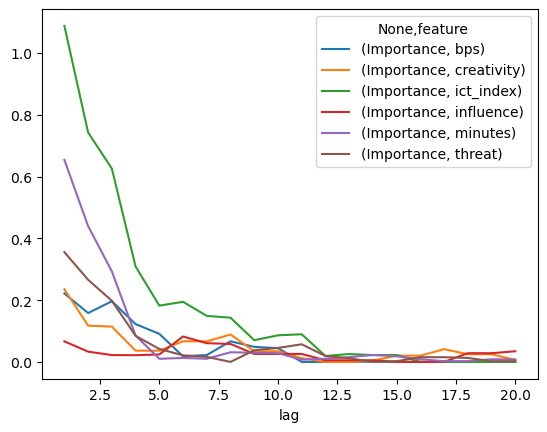

In [279]:
time_varying_unknown_reals_importances = importances.loc[TIME_VARYING_UNKNOWN_REALS_TRANSFORMED ].to_frame()
time_varying_unknown_reals_importances['lag'] = time_varying_unknown_reals_importances.index.str.split('_').str[-1]
time_varying_unknown_reals_importances['lag']  = time_varying_unknown_reals_importances['lag'].str.extract('(\d+)').astype(int)
time_varying_unknown_reals_importances['feature'] = time_varying_unknown_reals_importances.index.str.split('_').str[:-1].str.join('_')
time_varying_unknown_reals_importances = time_varying_unknown_reals_importances.sort_values(by=['lag']).reset_index(drop=True)
time_varying_unknown_reals_importances = time_varying_unknown_reals_importances.set_index(['lag','feature']).unstack().rolling(3,min_periods=1).mean()
time_varying_unknown_reals_importances .plot()
plt.show()


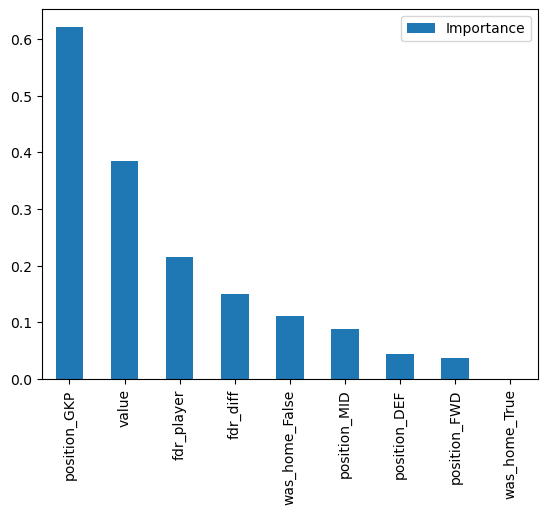

In [280]:
time_varying_unknown_reals_importances = importances.loc[TIME_VARYING_KNOWN_REALS+STATIC_REALS+model_pipe['preprocessor'].transformers_[1][1]\
    ['one_hot'].get_feature_names(STATIC_CATEGORICALS).tolist()].to_frame()
    
time_varying_unknown_reals_importances.sort_values(by='Importance',ascending=False).plot.bar()
plt.show()